In [13]:
# 1. IMPORTS
import os
import glob
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tifffile import imread

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from google.colab import drive
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# 2. MOUNT DRIVE + UNZIP DATA

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/02456_DeepLearning/data.zip"
extract_path = "/content/data"

# Unzip only if needed (or overwrite as per original logic)
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_path)
    print("Inside /content/data:", os.listdir("/content/data"))
else:
    print(f"Warning: Zip file not found at {zip_path}")


# 3. DEFINE PATHS & PRELIMINARY CHECKS
root = "/content/data/data"

labeled_images_path    = f"{root}/labeled/images"
labeled_masks_path     = f"{root}/labeled/masks"
unlabeled_images_path  = f"{root}/unlabeled/1h_HT"
unlabeled_cropped_path = f"{root}/unlabeled/1h_HT_cropped"
pseudo_images_path     = f"{root}/pseudo/images"
pseudo_masks_path      = f"{root}/pseudo/masks"

# Create directories
os.makedirs(unlabeled_cropped_path, exist_ok=True)
os.makedirs(pseudo_images_path, exist_ok=True)
os.makedirs(pseudo_masks_path, exist_ok=True)

# Load raw unlabeled images list (needed for processing step)
unlabeled_images_raw = sorted(glob.glob(unlabeled_images_path + "/*.tif"))
print(f"Raw Unlabeled Images found: {len(unlabeled_images_raw)}")

Mounted at /content/drive
Inside /content/data: ['data']
Raw Unlabeled Images found: 120


In [3]:
# 4. PREPROCESSING (CROPPED CLASS)

class SimpleLargeCropPreprocessor:
    def __init__(self, crop_size=750, output_size=256):
        self.crop_size = crop_size
        self.output_size = output_size

    def get_centroid(self, img):
        # Normalize 0-255 for centroid calculation
        if img.dtype != np.uint8:
            img_8u = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            img_8u = img

        blurred = cv2.GaussianBlur(img_8u, (31, 31), 0)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        M = cv2.moments(thresh)
        if M["m00"] == 0:
            return None
        return (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    def process_image(self, img_path):
        try:
            if img_path.lower().endswith(('.tif', '.tiff')):
                img = imread(img_path).astype(np.float32)
            else:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            return None, None

        center = self.get_centroid(img)
        if center is None:
            return None, None
        cX, cY = center

        # Crop
        half = self.crop_size // 2
        start_x, start_y = cX - half, cY - half
        end_x, end_y = start_x + self.crop_size, start_y + self.crop_size

        crop = np.zeros((self.crop_size, self.crop_size), dtype=np.float32)

        src_sy, src_ey = max(0, start_y), min(img.shape[0], end_y)
        src_sx, src_ex = max(0, start_x), min(img.shape[1], end_x)
        dst_sy, dst_sx = max(0, -start_y), max(0, -start_x)

        h, w = src_ey - src_sy, src_ex - src_sx
        if h > 0 and w > 0:
            crop[dst_sy:dst_sy + h, dst_sx:dst_sx + w] = img[src_sy:src_ey, src_sx:src_ex]

        # Resize
        final_img = cv2.resize(crop, (self.output_size, self.output_size),
                               interpolation=cv2.INTER_LINEAR)

        # Normalize [0,1]
        if final_img.max() > final_img.min():
            final_img = (final_img - final_img.min()) / (final_img.max() - final_img.min())

        return final_img, center

In [4]:
# 5. BATCH CROP UNLABELED IMAGES

def batch_process_unlabeled():
    print("Starting batch processing...")

    # Initialize Preprocessor (crop_size=750 as per request)
    preprocessor = SimpleLargeCropPreprocessor(crop_size=750, output_size=256)

    count = 0
    for fpath in unlabeled_images_raw:
        basename = os.path.basename(fpath)

        # Process
        processed_img, center = preprocessor.process_image(fpath)

        if processed_img is None:
            print(f"Warning: Could not process {basename}")
            continue

        # Convert [0,1] float -> [0,255] uint8 for storage
        img_uint8 = (processed_img * 255).astype(np.uint8)

        # Define destinations
        dest_1 = os.path.join(unlabeled_cropped_path, basename)
        dest_2 = os.path.join(pseudo_images_path, basename)

        # Save to both locations
        cv2.imwrite(dest_1, img_uint8)
        cv2.imwrite(dest_2, img_uint8)

        count += 1
        if count % 20 == 0:
            print(f"Processed {count} images...")

    print(f"\nDone! Successfully processed and saved {count} images.")
    print(f"Locations:\n 1. {unlabeled_cropped_path}\n 2. {pseudo_images_path}")

# Execute Batch Processing
if len(unlabeled_images_raw) > 0:
    batch_process_unlabeled()
else:
    print("No unlabeled images found to process.")

Starting batch processing...
Processed 20 images...
Processed 40 images...
Processed 60 images...
Processed 80 images...
Processed 100 images...
Processed 120 images...

Done! Successfully processed and saved 120 images.
Locations:
 1. /content/data/data/unlabeled/1h_HT_cropped
 2. /content/data/data/pseudo/images


In [5]:
# 6. TRANSFORMS
def normalize_image_transform(img):
    """Normalizes a float PIL image to a [0, 1] tensor."""
    np_img = np.array(img, dtype=np.float32)
    min_val = np.min(np_img)
    max_val = np.max(np_img)

    if max_val - min_val > 1e-6:
        normalized_img = (np_img - min_val) / (max_val - min_val)
    else:
        normalized_img = np.zeros(np_img.shape, dtype=np.float32)

    return torch.from_numpy(normalized_img).unsqueeze(0)

image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform)
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img) <= 0).unsqueeze(0).float())
])

In [6]:
# 7. DATASETS

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.mask_transform = mask_transform
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        mask  = Image.open(self.mask_files[idx])
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

class UnlabeledCroppedDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
# 8. LOAD FILE LISTS (LABELED + CROPPED)
labeled_images = sorted(glob.glob(labeled_images_path + "/*.tif"))
labeled_masks  = sorted(glob.glob(labeled_masks_path  + "/*.tif"))
unlabeled_cropped_files = sorted(glob.glob(unlabeled_cropped_path + "/*.tif"))

print(f"\nFinal Data Counts:")
print(f" Labeled Images:        {len(labeled_images)}")
print(f" Labeled Masks:         {len(labeled_masks)}")
print(f" Unlabeled Cropped:     {len(unlabeled_cropped_files)}")

# Instantiate Datasets for Visualization
labeled_dataset = SegmentationDataset(
    image_files=labeled_images,
    mask_files=labeled_masks,
    transform=image_transform,
    mask_transform=mask_transform
)

if len(unlabeled_cropped_files) > 0:
    unlabeled_cropped_dataset = UnlabeledCroppedDataset(
        image_files=unlabeled_cropped_files,
        transform=image_transform
    )
else:
    print("Warning: No cropped images found. Check processing step.")
    unlabeled_cropped_dataset = None


Final Data Counts:
 Labeled Images:        22
 Labeled Masks:         22
 Unlabeled Cropped:     120



9.1 VISUALIZING LABELED DATA


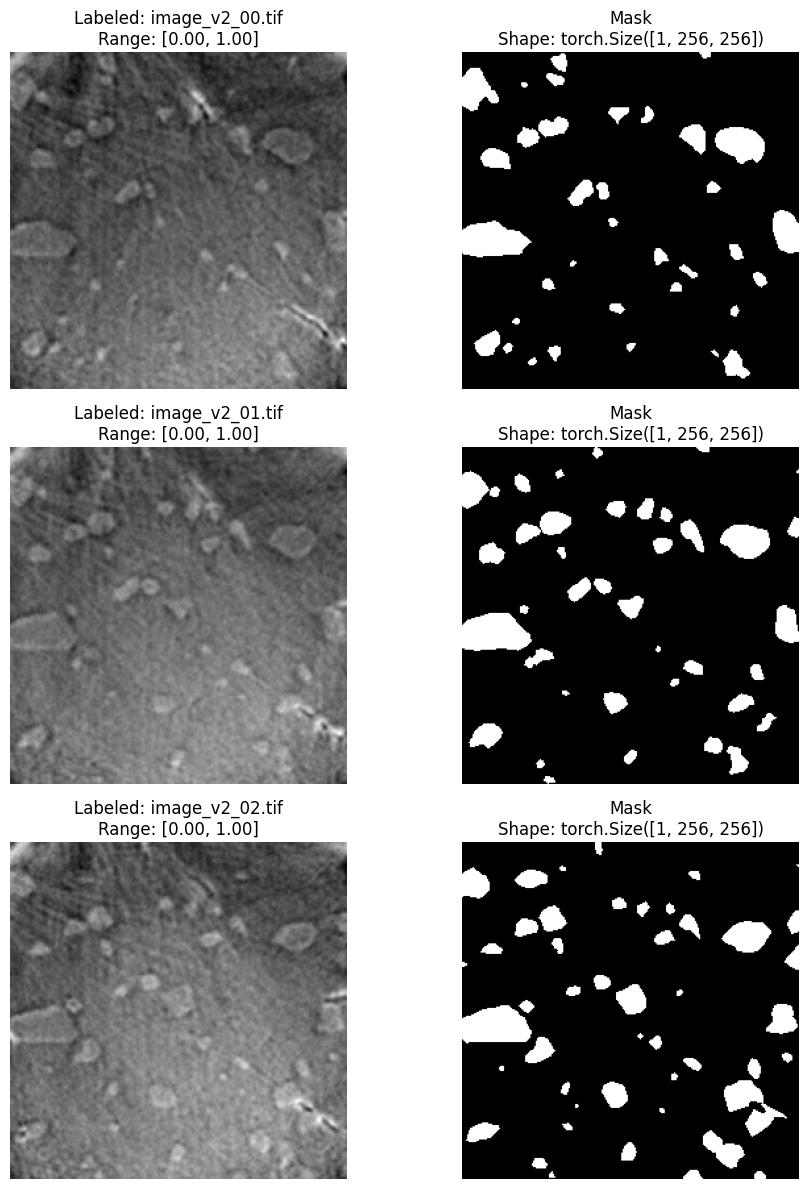

Sample 0 Stats -> Total: 65536, Pores: 6211 (9.48%)

--- 9.2 VISUALIZING UNLABELED RAW (Before Crop) ---


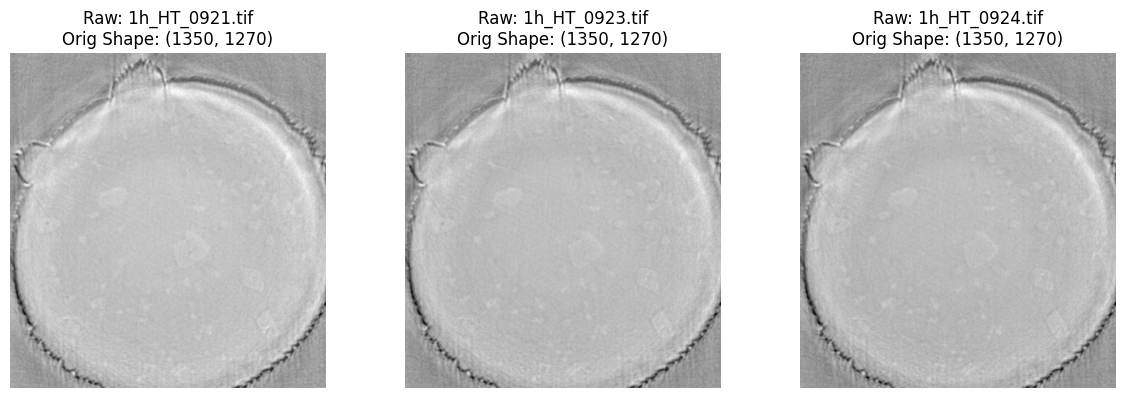


--- 9.3 VISUALIZING UNLABELED CROPPED (Input for Model) ---


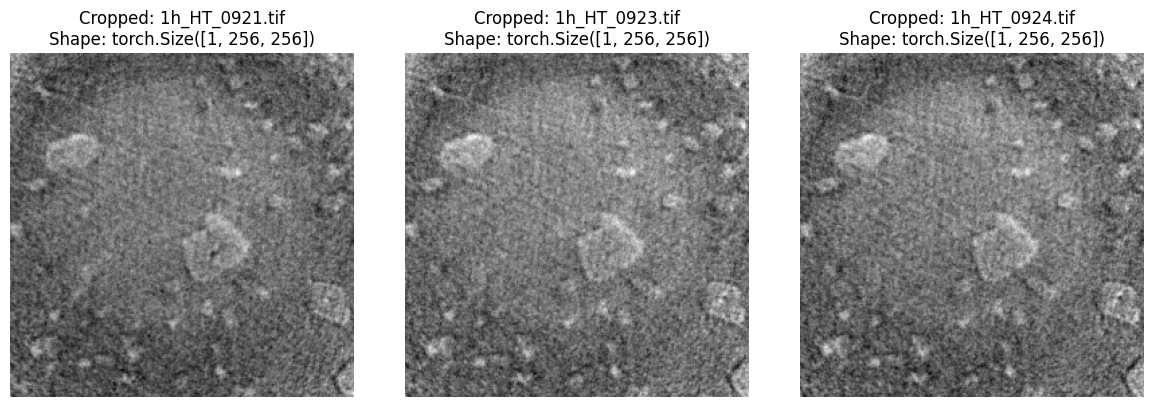

In [8]:
# 9. QUICK VISUAL CHECKS

# 9.1 Labeled (Image + Mask)
print("\n9.1 VISUALIZING LABELED DATA")
n_samples = 3
plt.figure(figsize=(10, n_samples * 4))

for i in range(min(n_samples, len(labeled_dataset))):
    image_tensor, mask_tensor = labeled_dataset[i]
    fname = os.path.basename(labeled_images[i])

    # Image
    plt.subplot(n_samples, 2, i*2 + 1)
    plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Labeled: {fname}\nRange: [{image_tensor.min():.2f}, {image_tensor.max():.2f}]")
    plt.axis('off')

    # Mask
    plt.subplot(n_samples, 2, i*2 + 2)
    plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Mask\nShape: {mask_tensor.shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()

if len(labeled_dataset) > 0:
    # Stats for Sample 0
    _, mask_t = labeled_dataset[0]
    pore_px = mask_t.sum().item()
    total_px = mask_t.numel()
    print(f"Sample 0 Stats -> Total: {total_px}, Pores: {int(pore_px)} ({pore_px/total_px*100:.2f}%)")

# --- 9.2 Unlabeled Raw ---
print("\n--- 9.2 VISUALIZING UNLABELED RAW (Before Crop) ---")
plt.figure(figsize=(12, 4))
for i in range(min(3, len(unlabeled_images_raw))):
    raw_path = unlabeled_images_raw[i]
    raw_img = imread(raw_path)
    fname = os.path.basename(raw_path)

    plt.subplot(1, 3, i+1)
    plt.imshow(raw_img, cmap='gray')
    plt.title(f"Raw: {fname}\nOrig Shape: {raw_img.shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# --- 9.3 Unlabeled Cropped ---
print("\n--- 9.3 VISUALIZING UNLABELED CROPPED (Input for Model) ---")
if unlabeled_cropped_dataset and len(unlabeled_cropped_dataset) > 0:
    plt.figure(figsize=(12, 4))
    for i in range(min(3, len(unlabeled_cropped_dataset))):
        crop_tensor = unlabeled_cropped_dataset[i]
        fname = os.path.basename(unlabeled_cropped_files[i])

        plt.subplot(1, 3, i+1)
        plt.imshow(crop_tensor.squeeze().numpy(), cmap='gray')
        plt.title(f"Cropped: {fname}\nShape: {crop_tensor.shape}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No cropped dataset available to visualize.")

In [11]:
import random

# 10. DATA LOADING & SPLITTING

# A. Prepare Labeled Data (Train/Val/Test)
full_labeled_dataset = SegmentationDataset(
    labeled_images,
    labeled_masks,
    transform=image_transform,
    mask_transform=mask_transform
)

# Split 80/10/10
# Note: With 22 images, this results in Train: 17, Val: 2, Test: 3
total_count = len(full_labeled_dataset)
train_size = int(0.8 * total_count)
val_size   = int(0.1 * total_count)
test_size  = total_count - train_size - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    full_labeled_dataset,
    [train_size, val_size, test_size],
    generator=generator
)

# B. Prepare Unlabeled Data (CORRECTION HERE)
# Use 'unlabeled_cropped_files' and 'UnlabeledCroppedDataset'
if len(unlabeled_cropped_files) > 0:
    unlabeled_dataset_full = UnlabeledCroppedDataset(
        unlabeled_cropped_files,
        transform=image_transform
    )
else:
    print("Error: No cropped files found. Did you run the batch processing?")

# C. Create Loaders
# Warning: With only 17 training images, Batch Size 8 results in a last batch of size 1.
# BatchNorm layers will crash with batch_size=1. We set drop_last=True to prevent this.
BATCH_SIZE = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Loader for generating pseudo-labels (Batch size 1 is safest for generation loops)
unlabeled_loader = DataLoader(unlabeled_dataset_full, batch_size=1, shuffle=False)

print("\nData preparation complete.")
print(f"Train batches: {len(train_loader)} (Batch Size: {BATCH_SIZE})")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")
print(f"Unlabeled images ready: {len(unlabeled_dataset_full)}")


Data preparation complete.
Train batches: 4 (Batch Size: 4)
Val batches:   1
Test batches:  1
Unlabeled images ready: 120


In [14]:
# 11. LOSS FUNCTION

class CombinedLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, y_true, mu, logvar, beta):
        # 1. Pixel-wise Loss (BCE + Dice)
        # BCE provides stable gradients early on; Dice optimizes the overlap
        bce_loss = self.bce(logits, y_true)

        y_true = y_true.float()
        probs = torch.sigmoid(logits)

        # Flatten for Dice
        inputs = probs.view(probs.shape[0], -1)
        targets = y_true.view(y_true.shape[0], -1)

        intersection = (inputs * targets).sum(dim=1)
        dice = (2. * intersection + self.smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + self.smooth)
        dice_loss = 1 - dice.mean()

        rec_loss = bce_loss + dice_loss

        # 2. KL Divergence
        # Clamp logvar to prevent NaN in exp()
        logvar = torch.clamp(logvar, min=-10, max=10)
        # Sum over latent dim, mean over batch
        kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

        # 3. Total
        # We scale KL by a small factor because reconstruction loss is ~1.0,
        # while raw KL can be huge.
        total_loss = rec_loss + (beta * kl_loss)

        return total_loss, rec_loss, kl_loss

In [15]:
# 12. MODELS

import torch
import torch.nn as nn
import torch.nn.functional as F

# 1) DoubleConv

class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

# 2) Split UNet into Encoder + Decoder

class UNetEncoder(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # Match these channel sizes to your original UNet
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck_conv = DoubleConv(512, 1024)  # this is your original bottleneck

    def forward(self, x):
        e1 = self.enc1(x)               # [B,  64, H,   W  ]
        e2 = self.enc2(self.pool1(e1))  # [B, 128, H/2, W/2]
        e3 = self.enc3(self.pool2(e2))  # [B, 256, H/4, W/4]
        e4 = self.enc4(self.pool3(e3))  # [B, 512, H/8, W/8]
        b  = self.bottleneck_conv(self.pool4(e4))  # [B,1024,H/16,W/16]
        return e1, e2, e3, e4, b


class UNetDecoder(nn.Module):
    def __init__(self, out_channels=1):
        super().__init__()

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4    = DoubleConv(512 + 512, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3    = DoubleConv(256 + 256, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2    = DoubleConv(128 + 128, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1    = DoubleConv(64 + 64, 64)

        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, z_feat, e1, e2, e3, e4):
        # z_feat replaces the old "b" at the bottom of the UNet
        d4 = self.upconv4(z_feat)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        out = self.output_conv(d1)
        return out


# 3) VAE Bottlenec

class VAEBottleneck(nn.Module):
    def __init__(self, in_channels=1024, z_dim=32):
        super().__init__()

        # 1. Downsample spatially to reduce parameters
        # Input: [B, 1024, 16, 16]
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),   # [B, 256, 16, 16]
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 128, 3, stride=2, padding=1), # [B, 128, 8, 8]
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=2, padding=1), # [B, 128, 4, 4]
            nn.BatchNorm2d(128), nn.ReLU(),
        )

        # 128 channels * 4 * 4 = 2048 features.
        # This is safe for a Linear layer.
        self.flat_dim = 128 * 4 * 4

        # 2. VAE Stats
        self.fc_mu = nn.Linear(self.flat_dim, z_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, z_dim)
        self.fc_decode = nn.Linear(z_dim, self.flat_dim)

        # 3. Upsample back to bottleneck size
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1), # [B, 128, 8, 8]
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 256, 3, stride=2, padding=1, output_padding=1), # [B, 256, 16, 16]
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, in_channels, 3, padding=1), # [B, 1024, 16, 16]
            nn.BatchNorm2d(in_channels), nn.ReLU(),
        )

    def forward(self, x):
        # x: [B, 1024, 16, 16]
        enc = self.encoder_conv(x)
        B, C, H, W = enc.shape

        flat = enc.view(B, -1)
        mu = self.fc_mu(flat)
        logvar = self.fc_logvar(flat)

        # Reparameterize
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # Decode
        dec_flat = self.fc_decode(z)
        dec_view = dec_flat.view(B, C, H, W)
        out = self.decoder_conv(dec_view) # [B, 1024, 16, 16]

        return out, mu, logvar

class SkipVAEUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, z_dim=32):
        super().__init__()
        self.encoder = UNetEncoder(in_channels)
        self.bottleneck = VAEBottleneck(in_channels=1024, z_dim=z_dim)
        self.decoder = UNetDecoder(out_channels)

    def forward(self, x):
        e1, e2, e3, e4, b = self.encoder(x)
        z_feat, mu, logvar = self.bottleneck(b)
        logits = self.decoder(z_feat, e1, e2, e3, e4)
        return logits, mu, logvar

In [22]:
# 3. TEACHER TRAINING LOOP
# (Standard Supervised Training on 'train_loader')

import random
import numpy as np
import torch
import torch.optim as optim
from time import time

SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"Reproducibility seed set to {SEED}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model
model = SkipVAEUNet(in_channels=1, out_channels=1, z_dim=32).to(device)

learning_rate = 1e-4
opt = optim.Adam(model.parameters(), learning_rate)
criterion = CombinedLoss(smooth=1.0)

epochs = 100

# different betas
# kl_scale = 0.1
# kl_scale = 0.01
kl_scale = 0.001

train_losses = []
val_losses = []

print("\nStarting Teacher Training (Labeled Data Only)...")

for epoch in range(epochs):
    tic = time()
    anneal_factor = min(1.0, epoch / (epochs / 2))
    beta = anneal_factor * kl_scale

    # Training Phase
    model.train()
    avg_rec_loss = 0.0
    avg_kl = 0.0

    # Note: 'train_loader' is already defined from previous data prep step
    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        opt.zero_grad()
        logits, mu, logvar = model(X_batch)
        loss, rec_loss, kl_loss_val = criterion(logits, y_true, mu, logvar, beta)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        avg_rec_loss += rec_loss.item() / len(train_loader)
        avg_kl       += kl_loss_val.item() / len(train_loader)

    # Validation Phase
    model.eval()
    avg_val_rec = 0.0
    avg_val_kl = 0.0

    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            logits, mu, logvar = model(X_batch)
            loss, rec_loss, kl_loss_val = criterion(logits, y_true, mu, logvar, beta)

            avg_val_rec += rec_loss.item() / len(val_loader)
            avg_val_kl  += kl_loss_val.item() / len(val_loader)

    toc = time()
    train_losses.append(avg_rec_loss + beta * avg_kl)
    val_losses.append(avg_val_rec + beta * avg_val_kl)

    if (epoch+1) % 5 == 0:
        print(f'* Epoch {epoch+1:02d}/{epochs} (beta={beta:.5f})')
        print(f'  - Train Total: {avg_rec_loss + beta*avg_kl:.4f}')
        print(f'  - Val Total:   {avg_val_rec + beta*avg_val_kl:.4f}')

print("\nTeacher training finished!")

# SAVE THE TEACHER MODEL
torch.save(model.state_dict(), "teacher_skip_vae.pth")
print("Teacher weights saved to 'teacher_skip_vae.pth'")

Reproducibility seed set to 42
Using device: cuda

Starting Teacher Training (Labeled Data Only)...
* Epoch 05/100 (beta=0.00008)
  - Train Total: 0.9623
  - Val Total:   1.2653
* Epoch 10/100 (beta=0.00018)
  - Train Total: 0.7669
  - Val Total:   1.0254
* Epoch 15/100 (beta=0.00028)
  - Train Total: 0.6805
  - Val Total:   0.7623
* Epoch 20/100 (beta=0.00038)
  - Train Total: 0.6272
  - Val Total:   0.6717
* Epoch 25/100 (beta=0.00048)
  - Train Total: 0.5848
  - Val Total:   0.6448
* Epoch 30/100 (beta=0.00058)
  - Train Total: 0.5501
  - Val Total:   0.6310
* Epoch 35/100 (beta=0.00068)
  - Train Total: 0.5083
  - Val Total:   0.5893
* Epoch 40/100 (beta=0.00078)
  - Train Total: 0.4867
  - Val Total:   0.5825
* Epoch 45/100 (beta=0.00088)
  - Train Total: 0.4619
  - Val Total:   0.5688
* Epoch 50/100 (beta=0.00098)
  - Train Total: 0.4360
  - Val Total:   0.5499
* Epoch 55/100 (beta=0.00100)
  - Train Total: 0.4155
  - Val Total:   0.5478
* Epoch 60/100 (beta=0.00100)
  - Train To

Loaded weights from 'teacher_skip_vae.pth' for evaluation.

Evaluating on 3 test images...

--- Test Results ---
Average Dice Score:        0.8119
Average IoU Score:         0.6834
Average Accuracy:          0.9611
Average Precision:         0.8274
Average Sensitivity (Rec): 0.7989
Average Specificity:       0.9804


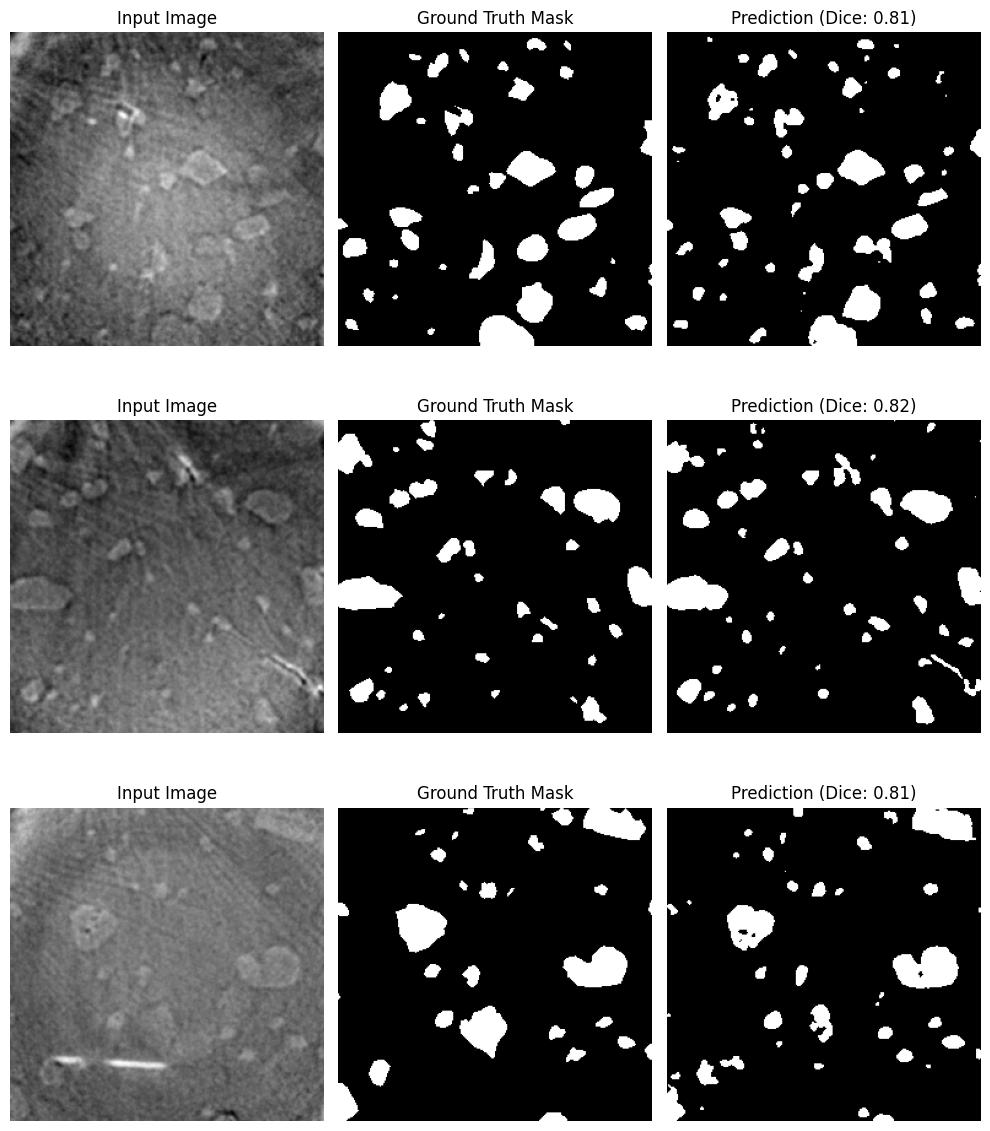

In [23]:
def evaluate_and_visualize(model, loader, device='cuda', threshold=0.5):
    model.eval()
    model.to(device)

    # 1. Load the best weights
    weights_path = "teacher_skip_vae.pth"
    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device))
        print(f"Loaded weights from '{weights_path}' for evaluation.")
    else:
        print(f"Warning: '{weights_path}' not found. Using current model weights.")

    dice_scores = []
    iou_scores  = []
    acc_scores  = []
    prec_scores = []
    sens_scores = []   # sensitivity / recall
    spec_scores = []

    # Lists to store samples for visualization
    vis_images = []
    vis_masks  = []
    vis_preds  = []

    print(f"\nEvaluating on {len(loader.dataset)} test images...")

    eps = 1e-6  # numerical stability

    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            images = images.to(device)
            masks  = masks.to(device)

            # 2. Forward Pass
            logits, _, _ = model(images)

            # Apply Sigmoid to get probabilities [0,1]
            probs = torch.sigmoid(logits)

            # Threshold to get binary mask {0,1}
            preds = (probs > threshold).float()

            # 3. Calculate Metrics per Sample
            for j in range(images.size(0)):
                p_flat = preds[j].view(-1)
                m_flat = masks[j].view(-1)

                # Basic counts
                intersection = (p_flat * m_flat).sum().item()
                p_sum = p_flat.sum().item()
                m_sum = m_flat.sum().item()

                # Dice
                dice = (2.0 * intersection) / (p_sum + m_sum + eps)
                dice_scores.append(dice)

                # IoU
                union = p_sum + m_sum - intersection
                iou = intersection / (union + eps)
                iou_scores.append(iou)

                # Confusion matrix components
                tp = intersection
                fp = (p_flat * (1 - m_flat)).sum().item()
                fn = ((1 - p_flat) * m_flat).sum().item()
                tn = ((1 - p_flat) * (1 - m_flat)).sum().item()

                # Derived metrics
                acc  = (tp + tn) / (tp + tn + fp + fn + eps)
                prec = tp / (tp + fp + eps)
                sens = tp / (tp + fn + eps)   # sensitivity / recall
                spec = tn / (tn + fp + eps)

                acc_scores.append(acc)
                prec_scores.append(prec)
                sens_scores.append(sens)
                spec_scores.append(spec)

                # Save first 3 samples for visualization
                if len(vis_images) < 3:
                    vis_images.append(images[j].cpu())
                    vis_masks.append(masks[j].cpu())
                    vis_preds.append(preds[j].cpu())

    # Averages
    avg_dice = np.mean(dice_scores)
    avg_iou  = np.mean(iou_scores)
    avg_acc  = np.mean(acc_scores)
    avg_prec = np.mean(prec_scores)
    avg_sens = np.mean(sens_scores)
    avg_spec = np.mean(spec_scores)

    print(f"\n--- Test Results ---")
    print(f"Average Dice Score:        {avg_dice:.4f}")
    print(f"Average IoU Score:         {avg_iou:.4f}")
    print(f"Average Accuracy:          {avg_acc:.4f}")
    print(f"Average Precision:         {avg_prec:.4f}")
    print(f"Average Sensitivity (Rec): {avg_sens:.4f}")
    print(f"Average Specificity:       {avg_spec:.4f}")

    # 4. Visualization
    n_plot = len(vis_images)
    plt.figure(figsize=(10, 4 * n_plot))

    for k in range(n_plot):
        # Image
        plt.subplot(n_plot, 3, k*3 + 1)
        plt.imshow(vis_images[k].squeeze().numpy(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        # Ground Truth
        plt.subplot(n_plot, 3, k*3 + 2)
        plt.imshow(vis_masks[k].squeeze().numpy(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Prediction
        plt.subplot(n_plot, 3, k*3 + 3)
        plt.imshow(vis_preds[k].squeeze().numpy(), cmap='gray')
        plt.title(f"Prediction (Dice: {dice_scores[k]:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run Evaluation
# Ensure 'model' is initialized and 'test_loader' is available
evaluate_and_visualize(model, test_loader, device=device)